In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import json

sys.path.insert(0, "./../")
from FileManager import FileManager
from ExptTrace import ExptTrace
import utils
utils.rcsetup()

In [2]:
qwem_dir = os.path.join(os.getenv("EXPTPATH"), "qwem", "qwem-small")
sgns_dir = os.path.join(os.getenv("EXPTPATH"), "qwem", "sgns-small")
qweml_dir = os.path.join(os.getenv("EXPTPATH"), "qwem", "qwem-large")
sgnsl_dir = os.path.join(os.getenv("EXPTPATH"), "qwem", "sgns-large")

def get_results(dir):
    fm = FileManager(dir)
    results = fm.load("results.pickle")
    with open(fm.get_filename("hypers.json")) as f:
        hypers = json.load(f)
    return hypers, *[ExptTrace.deserialize(x) for x in results]

_, _, _, et_sv_QWEM = get_results(qwem_dir)
QWEM_sv_t = np.array(et_sv_QWEM[:])

H, _, _, et_sv_SGNS = get_results(sgns_dir)
SGNS_sv_t = np.array(et_sv_SGNS[:])

_, _, _, et_sv_QWEML = get_results(qweml_dir)
QWEML_sv_t = np.array(et_sv_QWEML[:])

HL, _, _, et_sv_SGNSL = get_results(sgnsl_dir)
SGNSL_sv_t = np.array(et_sv_SGNSL[:])

VOCAB_SZ = H["vocab_sz"]
CONTEXT_LEN = H["context_len"]
LR = H["lr"]
EMBEDDIM = H["embeddim"]

In [3]:
data_dir = os.path.join(os.getenv("DATASETPATH"), "qwem")
data_fm = FileManager(data_dir)

analogy_dict = data_fm.load("analogies.pickle")
if analogy_dict is None:
    raise FileNotFoundError("Analogy file not found.")

data_fm.set_filepath("enwiki500")
word_counts = data_fm.load("word_counts.pickle")

vocab = utils.Vocabulary(word_counts[:VOCAB_SZ])
unigram = vocab.counts / vocab.counts.sum()
analogy_dataset = utils.AnalogyDataset(analogy_dict, vocab)

data_fm.set_filepath(f"enwiki500/REC-eigh-V{VOCAB_SZ//1000}k")
eigvecs = data_fm.load("eigvecs.npy")
eigvals = data_fm.load("eigvals.npy")
data_fm.set_filepath(f"enwiki500")
if eigvecs is None or eigvals is None:
    raise FileNotFoundError("Run mstar_eigh.ipynb first.")
W_Mstar = eigvecs[:, :EMBEDDIM] @ np.diag(eigvals[:EMBEDDIM])

In [4]:
def get_min_loss():
    corpus_stats = data_fm.load("corpus_stats.pickle")
    cL = corpus_stats["context_len"]
    Cij, Crwij = corpus_stats["counts"], corpus_stats["counts_reweight"]
    numcounts = Cij[:VOCAB_SZ, :VOCAB_SZ].sum()
    Pij = Crwij[:VOCAB_SZ, :VOCAB_SZ] / (numcounts * (cL + 1)/2)
    PiPj = np.outer(unigram, unigram)
    Mstar = 2*(Pij - PiPj)/(Pij + PiPj)
    min_loss = -1 * (Mstar**2).mean()
    return min_loss

min_loss = get_min_loss()

In [5]:
def get_tchar(lambda_init, lr, min_loss):
    lambda_max = np.max(eigvals)
    lr_eff = (-1/min_loss) * lr * 4 / (VOCAB_SZ**2)
    tscale = (1/lambda_max) * np.log(lambda_max/lambda_init)
    tchar = tscale / lr_eff
    return tscale, tchar


def theorycurve(t, lstar, tscale, lambda_init):
    t = t * tscale
    t[lstar * t > 100] = 100/lstar
    numer = np.exp(lstar * t)
    denom = 1/lambda_init + (numer-1)/lstar
    return np.sqrt(numer / denom)


lambda_init = H["init_sz"]**2
lr = H["lr"]
tscale, tchar = get_tchar(lambda_init, lr, min_loss)
QWEM_tt = np.array(et_sv_QWEM.get_axis("nstep"), dtype=np.float32) / tchar
SGNS_tt = np.array(et_sv_SGNS.get_axis("nstep"), dtype=np.float32) / tchar
QWEM_th_tt = np.logspace(-1, 2, num=1000, base=10)
QWEM_th_sv_t = np.empty((len(QWEM_th_tt), EMBEDDIM))
for j, eigval in enumerate(eigvals[:EMBEDDIM]):
    QWEM_th_sv_t[:, j] = theorycurve(QWEM_th_tt, eigval, tscale, lambda_init)

lambda_init = HL["init_sz"]**2
lr = HL["lr"]
tscale, tchar = get_tchar(lambda_init, lr, min_loss)
QWEML_tt = np.array(et_sv_QWEML.get_axis("nstep"), dtype=np.float32) / tchar
SGNSL_tt = np.array(et_sv_SGNSL.get_axis("nstep"), dtype=np.float32) / tchar
QWEML_th_tt = np.logspace(-1, 2, num=1000, base=10)
QWEML_th_sv_t = np.empty((len(QWEML_th_tt), EMBEDDIM))
for j, eigval in enumerate(eigvals[:EMBEDDIM]):
    QWEML_th_sv_t[:, j] = theorycurve(QWEML_th_tt, eigval, tscale, lambda_init)

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


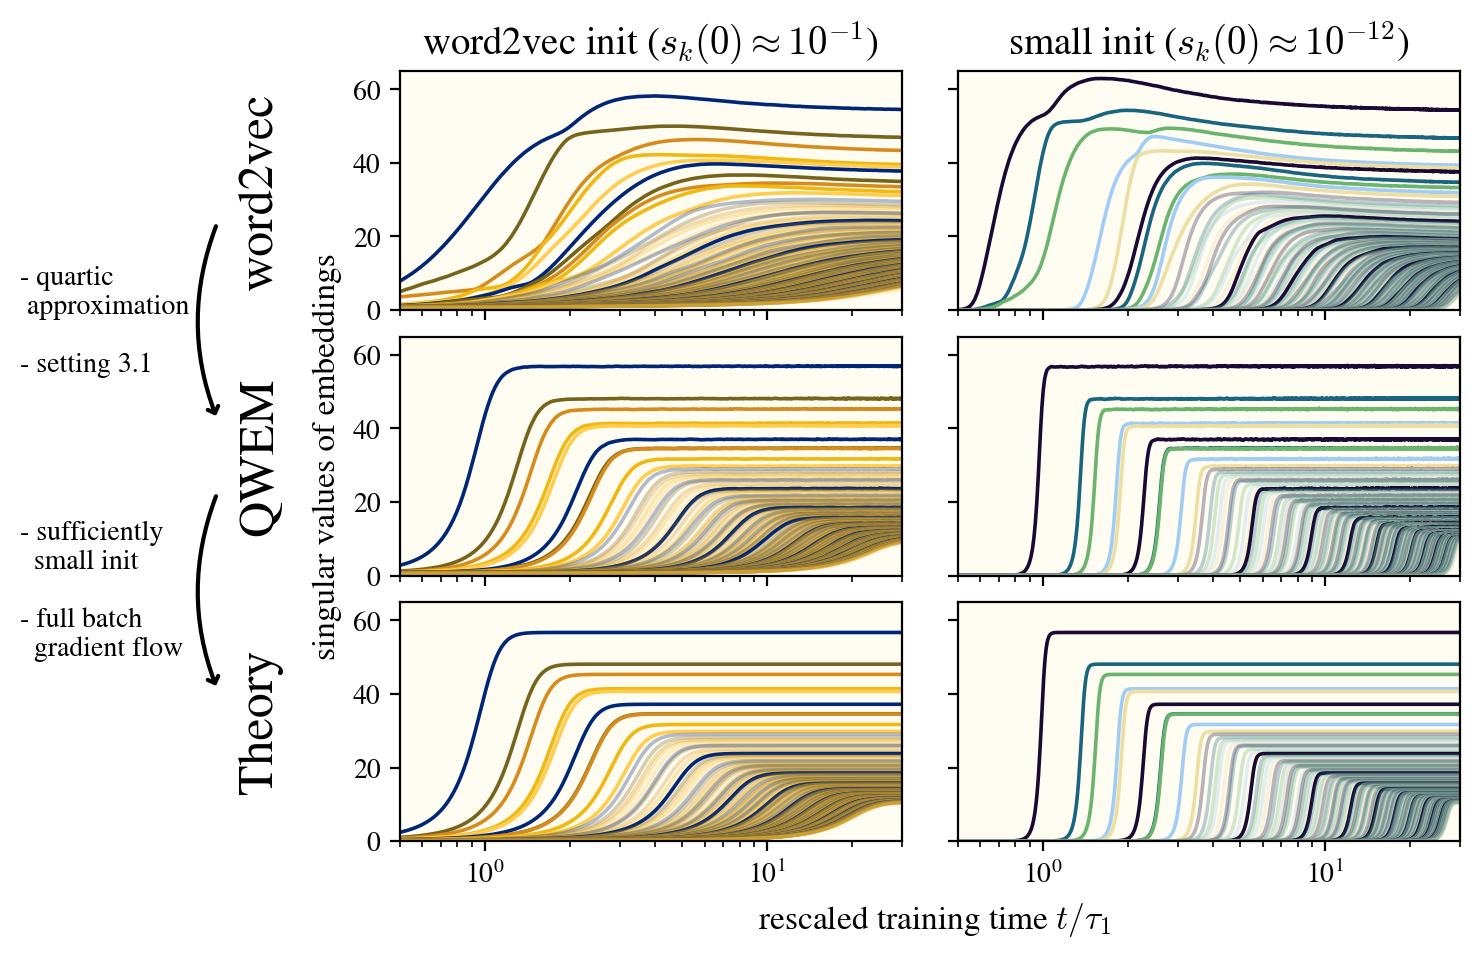

In [6]:
results = [
    [SGNSL_tt, SGNSL_sv_t, SGNS_tt, SGNS_sv_t],
    [QWEML_tt, QWEML_sv_t, QWEM_tt, QWEM_sv_t],
    [QWEML_th_tt, QWEML_th_sv_t, QWEM_th_tt, QWEM_th_sv_t],
]

def get_sv_color(j, scheme=0):
    colors = [
        "#002676 #76641C #D68C1D #F0B811 #FFCD50".split(" "),
        "#190933 #19647E #6BB46D #A1CDF4 #EDDEA4".split(' ')
    ]
    colors = colors[scheme]
    color = colors[j%5]
    if j < 10:
        alpha = 1
    elif j%20 == 0:
        alpha = 1
    else:
        alpha=0.3
    return color, alpha

fig = plt.figure(figsize=(9, 5), dpi=200)
rs = [slice(12, 30), slice(32, 50)]
cs = [slice(0,9), slice(10,19), slice(20,29)]
gs = fig.add_gridspec(29, 50, wspace=0, hspace=0)

axes = []
for rowlabel, cslice in zip(["word2vec", "QWEM", "Theory"], cs):
    row = [
        fig.add_subplot(gs[cslice, rs[0]]),
        fig.add_subplot(gs[cslice, rs[1]]),
    ]
    axes.append(row)

    ax_label = fig.add_subplot(gs[cslice, 7:12])
    ax_label.axis("off")
    ax_label.text(0., 0.5, rowlabel, fontsize=18, ha='center', va='center', rotation=90)


ax_annotation = fig.add_subplot(gs[:, 0:6])
ax_annotation.axis("off")

for i, row in enumerate(axes):
    ttl, svl_t, tt, sv_t = results[i]
    ax_sv, ax_sv2 = row
    ax_sv2.tick_params(axis='y', labelleft=False)
    if i == 0:
        ax_sv.set_title(r"word2vec init ($s_k(0) \approx 10^{-1}$)", fontsize=14)
        ax_sv2.set_title(r"small init ($s_k(0) \approx 10^{-12}$)", fontsize=14)
    if i == 1:
        ax_sv.set_ylabel("singular values of embeddings")
    if i == 2:
        ax_sv.set_xlabel(" "*68 + r"rescaled training time $t/\tau_1$")
    if i != 2:
        ax_sv.tick_params(axis='x', labelbottom=False)
        ax_sv2.tick_params(axis='x', labelbottom=False)
    
    for j, svs in enumerate(svl_t.T):
        color, alpha = get_sv_color(j)
        if i!=0:
            ax_sv.plot(ttl, svs, color=color, alpha=alpha, lw=1.3, zorder=-3)
        else:
            ax_sv.plot(1.1*ttl, svs, color=color, alpha=alpha, ls="-", lw=1.3)
    
    for j, svs in enumerate(sv_t.T):
        color, alpha = get_sv_color(j, scheme=1)
        if i!=0:
            ax_sv2.plot(tt, svs, color=color, alpha=alpha, lw=1.3, zorder=-3)
        else:
            ax_sv2.plot(1.1*tt, svs, color=color, alpha=alpha, ls="-", lw=1.3)
    
    for ax in row:
        ax.tick_params(axis='both', labelsize=10)
        ax.set_xscale('log')
        ax.set_xlim(.5, 30)
        ax.set_ylim(0, 65)

from matplotlib.patches import FancyArrowPatch
for i in range(2):
    mid = [0.63, 0.36][i]
    annotation = [
        "- quartic\n approximation\n\n- setting 3.1",
        "- sufficiently\n  small init\n\n- full batch\n  gradient flow"
    ][i]
    arrow = FancyArrowPatch(
        posA=(.21, mid+.1),  # y coords spaced down
        posB=(.21, mid-.1),
        connectionstyle="arc3,rad=0.2",
        arrowstyle="->,head_length=2,head_width=2",
        transform=fig.transFigure,
        linewidth=1.5,
    )
    fig.patches.append(arrow)
    fig.text(0.1, mid, annotation, fontsize=10, verticalalignment="center")
    
plt.savefig('./figures/fig2.pdf', format='pdf', bbox_inches='tight')
# plt.show()